# Filter ChEMBL Affinity Data

This notebook filters ChEMBL affinity data stored in Parquet files, replicating the filtering logic from `ChEMBL32_OverlappingIC50s-paper.ipynb`.

## 1. Import Libraries and Load Data

# ChEMBL Data Filtering Pipeline

This notebook filters ChEMBL bioactivity data using:
1. **Quality filters** from the overlapping IC50s paper
2. **Lipinski's Rule of 5** for drug-like molecules

**Input:** `data/raw/` - Per-UniProt ChEMBL activity files  
**Output:** `data/chembl_filtered.parquet` - Filtered bioactivity data

## 1. Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import RDKit for Lipinski property calculations
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Lipinski
    RDKIT_AVAILABLE = True
    print("✓ RDKit imported successfully for molecular property calculations")
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠ RDKit not available - will use existing Lipinski properties only")

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

✓ RDKit imported successfully for molecular property calculations
Libraries imported successfully!


## 2. Load Raw ChEMBL Data

Load all ChEMBL activity data from the `data/raw/` directory (per-UniProt parquet files).

In [5]:
# Define paths
raw_data_dir = Path('data/chembl_parallel_enriched')
output_file = Path('data/chembl_activities_enriched.parquet')
output_file.parent.mkdir(parents=True, exist_ok=True)

# Find all ChEMBL activity parquet files
activity_files = list(raw_data_dir.glob('uniprot_*/*_chembl_activities.parquet'))

print(f"Found {len(activity_files)} UniProt activity files")
print(f"Example: {activity_files[0] if activity_files else 'None'}")

Found 0 UniProt activity files
Example: None


In [6]:
# Load all activity data
print("Loading ChEMBL activity data...")
all_activities = []

for i, file in enumerate(activity_files):
    if (i + 1) % 100 == 0:
        print(f"  Loaded {i + 1}/{len(activity_files)} files...")
    
    try:
        df = pd.read_parquet(file)
        all_activities.append(df)
    except Exception as e:
        print(f"  Error loading {file}: {e}")

# Combine all data
df_all = pd.concat(all_activities, ignore_index=True)

print(f"\n✓ Loaded {len(df_all):,} total activities")
print(f"  Unique compounds: {df_all['molecule_chembl_id'].nunique():,}")
print(f"  Unique UniProt IDs: {df_all['source_uniprot_id'].nunique():,}")
print(f"  Unique assays: {df_all['assay_chembl_id'].nunique():,}")
print(f"\nDataFrame shape: {df_all.shape}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loading ChEMBL activity data...


ValueError: No objects to concatenate

In [ ]:
tmp = pd.read_parquet("/home/aoxu/projects/VLS-Benchmark-Dataset/data/chembl_parallel_enriched/uniprot_Q30154/Q30154_chembl_activities.parquet")
print(tmp.shape)
tmp['canonical_smiles'].head()

(3000, 72)


0             c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1
1    Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...
2    COc1ccccc1-c1ccc2oc(-c3ccc(OC)c(N4C(=O)c5ccc(C...
3    Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...
4    Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...
Name: canonical_smiles, dtype: object

## 3. Initial Data Exploration

In [ ]:
# Display first few rows
print("Sample of raw data:")
display(df_all.head())

# Check data types and missing values
print("\n" + "="*80)
print("Column Information:")
print("="*80)
info_df = pd.DataFrame({
    'Column': df_all.columns,
    'Non-Null Count': [df_all[col].notna().sum() for col in df_all.columns],
    'Null Count': [df_all[col].isna().sum() for col in df_all.columns],
    'Dtype': [df_all[col].dtype for col in df_all.columns]
})
display(info_df)

Sample of raw data:


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_tissue_chembl_id,assay_target_chembl_id,assay_document_chembl_id,assay_src_id,assay_src_assay_id,assay_category,assay_parameters,assay_classifications,assay_variant_sequence,source_uniprot_id
0,None,None,31863,[],CHEMBL663853,Inhibitory concentration against human DNA top...,B,None,None,BAO_0000190,...,None,CHEMBL1806,CHEMBL1137930,1,None,None,None,None,None,Q77J90
1,None,None,31864,[],CHEMBL872937,In vivo inhibitory activity against human Hepa...,B,None,None,BAO_0000190,...,None,CHEMBL3921,CHEMBL1146658,1,None,None,None,None,None,Q77J90
2,None,None,31866,[],CHEMBL872937,In vivo inhibitory activity against human Hepa...,B,None,None,BAO_0000190,...,None,CHEMBL3921,CHEMBL1146658,1,None,None,None,None,None,Q77J90
3,None,None,31874,[],CHEMBL666153,Inhibition of cytochrome P450 1A2 of isolated ...,A,None,None,BAO_0000190,...,None,CHEMBL3356,CHEMBL1148425,1,None,None,None,None,None,Q77J90
4,None,None,31875,[],CHEMBL665756,Inhibition of cytochrome P450 3A4 of isolated ...,A,None,None,BAO_0000190,...,None,CHEMBL340,CHEMBL1148425,1,None,None,None,None,None,Q77J90



Column Information:


,Column,Non-Null Count,Null Count,Dtype
0,action_type,0,19713000,object
1,activity_comment,604532,19108468,object
2,activity_id,19713000,0,int64
3,activity_properties,19713000,0,object
4,assay_chembl_id,19713000,0,object
...,...,...,...,...
67,assay_category,0,19713000,object
68,assay_parameters,0,19713000,object
69,assay_classifications,387689,19325311,object
70,assay_variant_sequence,0,19713000,object


In [ ]:
# Check standard_type distribution
print("\nStandard Type Distribution:")
print(df_all['standard_type'].value_counts())

# Check standard_relation distribution
print("\nStandard Relation Distribution:")
print(df_all['standard_relation'].value_counts())

# Check confidence_score distribution
print("\nConfidence Score Distribution:")
print(df_all['assay_confidence_score'].value_counts(dropna=False))


Standard Type Distribution:
standard_type
IC50    11400685
Ki       6446151
EC50     1649321
Kd        216843
Name: count, dtype: int64

Standard Relation Distribution:
standard_relation
=     16282938
>      2634971
<       144562
~        13142
>=       13142
<=        6571
Name: count, dtype: int64

Confidence Score Distribution:
assay_confidence_score
8    13536260
1     2667826
9     1787312
4      689955
7      525680
6      341692
5      164275
Name: count, dtype: int64


In [ ]:
df_all.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value',
       'assay_description_enriched', 'assay_type_description',
       'assay_orga

In [ ]:
df_all['assay_description_enriched']

0           Inhibitory concentration against human DNA top...
1           In vivo inhibitory activity against human Hepa...
2           In vivo inhibitory activity against human Hepa...
3           Inhibition of cytochrome P450 1A2 of isolated ...
4           Inhibition of cytochrome P450 3A4 of isolated ...
                                  ...                        
19712995    Inhibition of phosphodiesterase fraction III i...
19712996    Inhibitory activity against matrix metalloprot...
19712997    Concentration required to inhibit the growth o...
19712998    Concentration required to inhibit the growth o...
19712999    Binding affinity to cloned human Dopamine rece...
Name: assay_description_enriched, Length: 19713000, dtype: object

## 4. Apply Quality Filters (From Overlapping IC50s Paper)

Apply the following filters based on the overlapping IC50s paper methodology:
- **pchembl_value**: Must be present (not null)
- **standard_type**: IC50, Ki, Kd, or EC50
- **standard_relation**: Must be '=' (exact measurement)
- **data_validity_comment**: Must be null (valid data)
- **confidence_score**: Must be 9 (high confidence)
- **Mutants/Variants**: Remove assays with mutant or variant mentions in description

In [ ]:
# Store filtering statistics
filter_stats = {}
filter_stats['initial'] = len(df_all)

print("="*80)
print("QUALITY FILTERING")
print("="*80)
print(f"\nInitial activities: {len(df_all):,}")

# Filter 1: pchembl_value must be present
df_filtered = df_all[df_all['pchembl_value'].notna()].copy()
filter_stats['after_pchembl'] = len(df_filtered)
print(f"After pchembl_value filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Convert pchembl_value to numeric (it may be stored as string)
df_filtered['pchembl_value'] = pd.to_numeric(df_filtered['pchembl_value'], errors='coerce')
df_filtered = df_filtered[df_filtered['pchembl_value'].notna()]
print(f"After converting to numeric: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 2: standard_type must be IC50, Ki, Kd, or EC50
valid_types = ['IC50', 'Ki', 'Kd', 'EC50']
df_filtered = df_filtered[df_filtered['standard_type'].isin(valid_types)]
filter_stats['after_standard_type'] = len(df_filtered)
print(f"After standard_type filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 3: standard_relation must be '='
df_filtered = df_filtered[df_filtered['standard_relation'] == '=']
filter_stats['after_relation'] = len(df_filtered)
print(f"After standard_relation filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 4: data_validity_comment must be null (valid data)
df_filtered = df_filtered[df_filtered['data_validity_comment'].isna()]
filter_stats['after_validity'] = len(df_filtered)
print(f"After data validity filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 5: confidence_score must be 9 (high confidence)
df_filtered = df_filtered[df_filtered['assay_confidence_score'] == 9]
filter_stats['after_confidence'] = len(df_filtered)
print(f"After confidence score filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# # Filter 6: Remove mutants/variants based on assay description
# # Check for mutant, mutation, variant in assay description (case-insensitive)
# if 'assay_description' in df_filtered.columns:
#     mutant_keywords = ['mutant', 'mutation', 'variant']
#     mutant_mask = df_filtered['assay_description'].fillna('').str.lower().str.contains('|'.join(mutant_keywords), regex=True)
#     df_filtered = df_filtered[~mutant_mask]
#     filter_stats['after_mutant'] = len(df_filtered)
#     print(f"After mutant/variant filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
# else:
#     print("Warning: 'assay_description' column not found, skipping mutant filter")
#     filter_stats['after_mutant'] = len(df_filtered)

# print(f"\n✓ Quality filtering complete")
# print(f"  Retained: {len(df_filtered):,} / {len(df_all):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
# print(f"  Removed: {len(df_all) - len(df_filtered):,} ({(len(df_all) - len(df_filtered))/len(df_all)*100:.1f}%)")

QUALITY FILTERING

Initial activities: 19,713,000
After pchembl_value filter: 15,211,865 (77.2%)
After converting to numeric: 15,211,865 (77.2%)
After standard_type filter: 15,211,865 (77.2%)
After standard_relation filter: 15,211,865 (77.2%)
After data validity filter: 15,211,865 (77.2%)
After confidence score filter: 1,399,623 (7.1%)


## 4.5. Remove Duplicates (From Overlapping IC50s Paper)

Following the overlapping IC50s paper methodology, we need to remove duplicates:
1. **Same Document Duplicates**: Remove duplicate activities from the same publication (document_chembl_id)
2. **Same Molecule-Assay Duplicates**: When multiple measurements exist for the same compound-assay combination, keep only one (typically the median or most recent)

In [ ]:
# Start with quality-filtered data
df_dedup = df_filtered.copy()

print("="*80)
print("DEDUPLICATION (Following Overlapping IC50s Paper Methodology)")
print("="*80)
print(f"\nStarting with {len(df_dedup):,} quality-filtered activities")

# Step 1: Generate assay conditions hash
# The overlapping paper creates an MD5 hash of assay experimental conditions
# to ensure only assays with identical conditions are grouped together
print("\nStep 1: Generate assay conditions hash")
print("  Creating hash from: assay_type, assay_organism_enriched, assay_category, assay_tax_id_enriched,")
print("                      assay_strain, assay_tissue_enriched, assay_cell_type_enriched, assay_subcellular_fraction_enriched,")
print("                      assay_bao_format_enriched, assay_variant_accession")

# Check which assay condition columns exist
# assay_condition_cols = [
#     'assay_organism_enriched', 'assay_tax_id_enriched',
#     'assay_tissue_enriched', 'assay_cell_type_enriched', 'assay_subcellular_fraction_enriched',
#     'assay_bao_format_enriched', 'assay_variant_accession'
# ]
#assay_cell_type_enriched	assay_tax_id_enriched assay_organism_enriched 
assay_condition_cols = [
    'assay_organism_enriched', 'assay_tax_id_enriched', 'assay_cell_type_enriched'
]
existing_cols = [col for col in assay_condition_cols if col in df_dedup.columns]
print(f"  Found {len(existing_cols)}/{len(assay_condition_cols)} columns: {existing_cols}")

if len(existing_cols) > 0:
    # Create assay conditions hash
    import hashlib
    
    def create_assay_hash(row):
        # Concatenate all assay condition values (converting None to empty string)
        condition_str = '|'.join([str(row[col]) if pd.notna(row[col]) else '' for col in existing_cols])
        return hashlib.md5(condition_str.encode()).hexdigest()
    
    df_dedup['assay_conditions_hash'] = df_dedup.apply(create_assay_hash, axis=1)
    print(f"  Generated {df_dedup['assay_conditions_hash'].nunique():,} unique assay condition combinations")
else:
    print("  Warning: No assay condition columns found, using assay_chembl_id as proxy")
    df_dedup['assay_conditions_hash'] = df_dedup['assay_chembl_id']
df_dedup

DEDUPLICATION (Following Overlapping IC50s Paper Methodology)

Starting with 1,399,623 quality-filtered activities

Step 1: Generate assay conditions hash
  Creating hash from: assay_type, assay_organism_enriched, assay_category, assay_tax_id_enriched,
                      assay_strain, assay_tissue_enriched, assay_cell_type_enriched, assay_subcellular_fraction_enriched,
                      assay_bao_format_enriched, assay_variant_accession
  Found 3/3 columns: ['assay_organism_enriched', 'assay_tax_id_enriched', 'assay_cell_type_enriched']
  Generated 10 unique assay condition combinations
  Generated 10 unique assay condition combinations


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_target_chembl_id,assay_document_chembl_id,assay_src_id,assay_src_assay_id,assay_category,assay_parameters,assay_classifications,assay_variant_sequence,source_uniprot_id,assay_conditions_hash
21,None,None,32121,[],CHEMBL754363,Inhibition of neutral endopeptidase 24.11(NEP),B,None,None,BAO_0000190,...,CHEMBL1944,CHEMBL1129909,1,None,None,None,None,None,Q77J90,ec67900e5d315480a67e1f72ebb4f42a
32,None,None,32187,[],CHEMBL616136,Affinity for 5-hydroxytryptamine 1A receptor s...,B,None,None,BAO_0000192,...,CHEMBL214,CHEMBL1150041,1,None,None,None,None,None,Q77J90,ec67900e5d315480a67e1f72ebb4f42a
33,None,None,32188,[],CHEMBL616937,Affinity for 5-hydroxytryptamine 1D receptor s...,B,None,None,BAO_0000192,...,CHEMBL1983,CHEMBL1150041,1,None,None,None,None,None,Q77J90,ec67900e5d315480a67e1f72ebb4f42a
34,None,None,32189,[],CHEMBL616433,Affinity for 5-hydroxytryptamine 1B receptor s...,B,None,None,BAO_0000192,...,CHEMBL1898,CHEMBL1150041,1,None,None,None,None,None,Q77J90,ec67900e5d315480a67e1f72ebb4f42a
43,None,None,32202,[],CHEMBL702320,Inhibition of TNF-alpha production from LPS st...,F,None,None,BAO_0000190,...,CHEMBL3706,CHEMBL1136542,1,None,None,None,None,None,Q77J90,ec67900e5d315480a67e1f72ebb4f42a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19712909,None,None,46996,[],CHEMBL618339,Antagonist activity against human A2B adenosin...,F,None,None,BAO_0000192,...,CHEMBL255,CHEMBL1132981,1,None,None,None,None,None,P80147,6cda13701d6c274fa929d7c9e597eea6
19712933,None,None,47121,[],CHEMBL648842,Inhibition of DHT binding to human androgen re...,B,None,None,BAO_0000192,...,CHEMBL1871,CHEMBL1145087,1,None,None,None,None,None,P80147,00508d81f89184f43a13085baf568eaf
19712934,None,None,47122,[],CHEMBL681751,Inhibition of Dexamethasone binding to human g...,B,None,None,BAO_0000192,...,CHEMBL2034,CHEMBL1145087,1,None,None,None,None,None,P80147,00508d81f89184f43a13085baf568eaf
19712935,None,None,47124,[],CHEMBL647746,Inhibition of human androgen receptor at 10e-1...,B,None,None,BAO_0000190,...,CHEMBL1871,CHEMBL1145087,1,None,None,None,None,None,P80147,ec67900e5d315480a67e1f72ebb4f42a


In [ ]:
df_dedup.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value',
       'assay_description_enriched', 'assay_type_description',
       'assay_orga

In [ ]:
df_dedup['assay_conditions_hash'].unique()

array(['ec67900e5d315480a67e1f72ebb4f42a',
       '70860b774dde48faa12d32921b7c7097',
       'cc11874037b302965436aa2e6e806171',
       'f944b8b7b1072abeba1559a9b7d7599c',
       'eb8ef6e274e1589ceb6e8b111fd60779',
       '6cda13701d6c274fa929d7c9e597eea6',
       '00508d81f89184f43a13085baf568eaf',
       '2b98422e448bcc376981f356bb10347e',
       '314c5aa3fff2fc1ee39d4eabe695862b',
       '875c0d54bb62a2fc1f00dea7c40c87fc'], dtype=object)

In [ ]:
df_filtered['pchembl_value'].unique()#.shape

array([ 8.16,  7.14,  9.15,  9.85,  5.04,  5.58,  6.52,  5.11,  5.6 ,
        7.4 ,  6.4 ,  6.36,  5.92,  6.13,  6.85,  5.93,  5.15,  5.47,
        8.3 ,  8.52,  8.86,  6.17,  7.08,  6.67,  7.  ,  5.72,  8.1 ,
        8.7 ,  9.1 ,  6.97,  8.89,  8.4 ,  6.33,  5.96,  8.06,  9.22,
        8.92,  7.77,  4.39,  6.35,  6.47,  7.75,  8.05,  7.72,  6.21,
        6.  ,  7.52,  9.4 ,  7.5 ,  8.75,  4.88,  8.32,  6.82,  8.44,
        5.06,  7.25,  5.88,  6.49,  8.15,  8.56,  8.66,  8.8 ,  7.26,
        7.28,  5.43,  7.7 ,  4.26,  7.11,  9.12,  8.29,  8.85,  8.77,
        7.06,  7.84,  4.02,  6.24,  8.74,  7.62,  6.38,  7.34,  6.7 ,
        7.24,  7.51,  7.09,  6.72,  4.13,  5.22,  5.82,  7.96,  5.8 ,
        6.57,  6.48,  7.38,  7.55,  6.77,  9.02,  6.45,  6.62,  6.22,
        5.75,  8.43,  8.63,  7.12,  7.22,  7.46,  6.92,  6.6 ,  7.42,
        7.6 ,  7.3 ,  6.15,  6.37,  6.78,  9.09,  8.6 ,  6.05,  7.01,
        7.48,  7.13,  5.57,  4.75,  8.  ,  7.32,  4.  ,  8.67,  7.05,
        8.22,  6.27,

In [ ]:

# Step 2: Document-level deduplication (keep largest assay per target-document pair)
# This matches: "distinct on (tid, doc_id)" from overlapping paper
# if 'document_chembl_id' in df_dedup.columns and 'target_chembl_id' in df_dedup.columns:
#     print("\nStep 2: Document-level deduplication (keep largest assay per target-document)")
    
#     # Count activities per assay
#     assay_sizes = df_dedup.groupby(['assay_chembl_id', 'target_chembl_id', 'document_chembl_id']).size().reset_index(name='assay_size')
#     df_dedup = df_dedup.merge(assay_sizes, on=['assay_chembl_id', 'target_chembl_id', 'document_chembl_id'])
    
#     # For each target-document pair, keep only the largest assay
#     before_doc = len(df_dedup)
#     df_dedup = df_dedup.sort_values('assay_size', ascending=False)
#     df_dedup = df_dedup.drop_duplicates(subset=['target_chembl_id', 'document_chembl_id'], keep='first')
#     df_dedup = df_dedup.drop(columns=['assay_size'])
#     filter_stats['after_doc_dedup'] = len(df_dedup)
    
#     print(f"  Before: {before_doc:,} activities")
#     print(f"  After:  {len(df_dedup):,} activities")
#     print(f"  Removed: {before_doc - len(df_dedup):,} ({(before_doc - len(df_dedup))/before_doc*100:.1f}%)")
# else:
#     print("\nStep 2: Skipped (document_chembl_id or target_chembl_id not found)")
#     filter_stats['after_doc_dedup'] = len(df_dedup)

# Step 3: Remove exact duplicates (same molecule-assay-value)
print("\nStep 3: Remove exact molecule-assay-value duplicates")
before_exact = len(df_dedup)

filter_stats['after_exact_dedup'] = len(df_dedup)
print(f"  Before: {before_exact:,} activities")
print(f"  After:  {len(df_dedup):,} activities")
print(f"  Removed: {before_exact - len(df_dedup):,} ({(before_exact - len(df_dedup))/before_exact*100:.1f}%)")



Step 3: Remove exact molecule-assay-value duplicates
  Before: 1,399,623 activities
  After:  1,399,623 activities
  Removed: 0 (0.0%)


124

## 5. Compute Missing Lipinski Properties with RDKit

Before applying Lipinski filters, compute any missing molecular properties using RDKit from SMILES strings.

**Lipinski's Rule of 5** criteria for drug-like molecules:
- **Molecular Weight (MW)**: ≤ 500 Da
- **LogP (lipophilicity)**: ≤ 5
- **Hydrogen Bond Donors (HBD)**: ≤ 5
- **Hydrogen Bond Acceptors (HBA)**: ≤ 10
- **Rule of 5 violations**: ≤ 1 (allowing one violation)

In [ ]:
# Check availability of Lipinski properties and SMILES
print("Checking Lipinski-related columns and SMILES availability:")
print("="*80)

# Check for SMILES column
smiles_col = None
for col_name in ['canonical_smiles', 'smiles', 'structure']:
    if col_name in df_dedup.columns:
        smiles_col = col_name
        print(f"✓ Found SMILES column: {smiles_col}")
        break

if not smiles_col:
    print("⚠ No SMILES column found - cannot compute missing properties")
    smiles_available = False
else:
    smiles_available = True
    non_null_smiles = df_dedup[smiles_col].notna().sum()
    print(f"  Non-null SMILES: {non_null_smiles:,} / {len(df_dedup):,} ({non_null_smiles/len(df_dedup)*100:.1f}%)")

# Check Lipinski property columns
lipinski_cols = ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']
print(f"\nLipinski property availability:")
for col in lipinski_cols:
    if col in df_dedup.columns:
        non_null = df_dedup[col].notna().sum()
        null_count = df_dedup[col].isna().sum()
        print(f"  {col}: {non_null:,} non-null, {null_count:,} null ({null_count/len(df_dedup)*100:.1f}%)")
    else:
        print(f"  {col}: NOT FOUND (will compute if possible)")

Checking Lipinski-related columns and SMILES availability:
✓ Found SMILES column: canonical_smiles
  Non-null SMILES: 44 / 44 (100.0%)

Lipinski property availability:
  molecular_weight: NOT FOUND (will compute if possible)
  alogp: NOT FOUND (will compute if possible)
  hbd: NOT FOUND (will compute if possible)
  hba: NOT FOUND (will compute if possible)
  num_ro5_violations: NOT FOUND (will compute if possible)


In [ ]:
# Compute missing Lipinski properties using RDKit
if RDKIT_AVAILABLE and smiles_available:
    print("\n" + "="*80)
    print("COMPUTING MISSING LIPINSKI PROPERTIES WITH RDKIT")
    print("="*80)
    
    def compute_lipinski_properties(smiles):
        """
        Compute Lipinski properties from SMILES using RDKit.
        
        Returns dict with: molecular_weight, alogp, hbd, hba, num_ro5_violations
        """
        if pd.isna(smiles) or smiles == '':
            return {
                'molecular_weight': None,
                'alogp': None,
                'hbd': None,
                'hba': None,
                'num_ro5_violations': None
            }
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {
                    'molecular_weight': None,
                    'alogp': None,
                    'hbd': None,
                    'hba': None,
                    'num_ro5_violations': None
                }
            
            # Compute properties
            mw = Descriptors.MolWt(mol)
            alogp = Descriptors.MolLogP(mol)
            hbd = Lipinski.NumHDonors(mol)
            hba = Lipinski.NumHAcceptors(mol)
            
            # Calculate Ro5 violations
            violations = 0
            if mw > 500:
                violations += 1
            if alogp > 5:
                violations += 1
            if hbd > 5:
                violations += 1
            if hba > 10:
                violations += 1
            
            return {
                'molecular_weight': mw,
                'alogp': alogp,
                'hbd': hbd,
                'hba': hba,
                'num_ro5_violations': violations
            }
        except Exception as e:
            return {
                'molecular_weight': None,
                'alogp': None,
                'hbd': None,
                'hba': None,
                'num_ro5_violations': None
            }
    
    # Identify rows that need computation
    needs_computation_mask = pd.Series(False, index=df_dedup.index)
    
    for col in ['molecular_weight', 'alogp', 'num_ro5_violations']:
        if col in df_dedup.columns:
            needs_computation_mask |= df_dedup[col].isna()
        else:
            needs_computation_mask = pd.Series(True, index=df_dedup.index)
            df_dedup[col] = None
    
    # Ensure hbd and hba columns exist
    if 'hbd' not in df_dedup.columns:
        df_dedup['hbd'] = None
    if 'hba' not in df_dedup.columns:
        df_dedup['hba'] = None
    
    rows_to_compute = needs_computation_mask.sum()
    print(f"\nRows needing property computation: {rows_to_compute:,} ({rows_to_compute/len(df_dedup)*100:.1f}%)")
    
    if rows_to_compute > 0:
        print(f"Computing Lipinski properties for {rows_to_compute:,} compounds...")
        
        # Compute properties for rows with missing values
        computed_props = df_dedup.loc[needs_computation_mask, smiles_col].apply(compute_lipinski_properties)
        computed_df = pd.DataFrame(computed_props.tolist(), index=computed_props.index)
        
        # Fill in missing values
        for col in ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']:
            # Only fill where values are null
            null_mask = df_dedup[col].isna()
            df_dedup.loc[null_mask, col] = computed_df.loc[null_mask, col]
        
        print("✓ Property computation complete!")
        
        # Report results
        print(f"\nProperty availability after computation:")
        for col in ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']:
            non_null = df_dedup[col].notna().sum()
            null_count = df_dedup[col].isna().sum()
            print(f"  {col}: {non_null:,} non-null, {null_count:,} null ({null_count/len(df_dedup)*100:.1f}%)")
    else:
        print("✓ All properties already available, no computation needed")
        
else:
    if not RDKIT_AVAILABLE:
        print("\n⚠ RDKit not available - skipping property computation")
        print("  Install with: pip install rdkit")
    elif not smiles_available:
        print("\n⚠ No SMILES column found - cannot compute properties")
    
    print("\n  Will use existing Lipinski properties only")


COMPUTING MISSING LIPINSKI PROPERTIES WITH RDKIT

Rows needing property computation: 44 (100.0%)
Computing Lipinski properties for 44 compounds...
✓ Property computation complete!

Property availability after computation:
  molecular_weight: 44 non-null, 0 null (0.0%)
  alogp: 44 non-null, 0 null (0.0%)
  hbd: 44 non-null, 0 null (0.0%)
  hba: 44 non-null, 0 null (0.0%)
  num_ro5_violations: 44 non-null, 0 null (0.0%)


In [ ]:
# Apply Lipinski's Rule of 5 filters
print("\n" + "="*80)
print("LIPINSKI'S RULE OF 5 FILTERING")
print("="*80)

df_lipinski = df_dedup.copy()

# Check distributions before filtering
print("\nLipinski Property Distributions (before filtering):")
if 'molecular_weight' in df_lipinski.columns:
    print(f"  Molecular Weight: mean={df_lipinski['molecular_weight'].mean():.1f}, median={df_lipinski['molecular_weight'].median():.1f}")
if 'alogp' in df_lipinski.columns:
    print(f"  ALogP: mean={df_lipinski['alogp'].mean():.2f}, median={df_lipinski['alogp'].median():.2f}")
if 'num_ro5_violations' in df_lipinski.columns:
    print(f"  Ro5 Violations: {df_lipinski['num_ro5_violations'].value_counts().sort_index().to_dict()}")

filter_stats['before_lipinski'] = len(df_lipinski)

# Filter: Molecular Weight ≤ 500 Da
if 'molecular_weight' in df_lipinski.columns:
    before_mw = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['molecular_weight'].notna()) & 
        (df_lipinski['molecular_weight'] <= 500)
    ]
    filter_stats['after_mw'] = len(df_lipinski)
    print(f"\nAfter MW ≤ 500 Da: {len(df_lipinski):,} ({len(df_lipinski)/before_mw*100:.1f}%)")
    print(f"  Removed: {before_mw - len(df_lipinski):,}")
else:
    print("\n⚠ molecular_weight column not available")

# Filter: ALogP ≤ 5
if 'alogp' in df_lipinski.columns:
    before_alogp = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['alogp'].notna()) & 
        (df_lipinski['alogp'] <= 5)
    ]
    filter_stats['after_alogp'] = len(df_lipinski)
    print(f"After ALogP ≤ 5: {len(df_lipinski):,} ({len(df_lipinski)/before_alogp*100:.1f}%)")
    print(f"  Removed: {before_alogp - len(df_lipinski):,}")
else:
    print("⚠ alogp column not available")

# Filter: Ro5 violations ≤ 1 (allowing one violation is common practice)
if 'num_ro5_violations' in df_lipinski.columns:
    before_ro5 = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['num_ro5_violations'].notna()) & 
        (df_lipinski['num_ro5_violations'] <= 1)
    ]
    filter_stats['after_ro5'] = len(df_lipinski)
    print(f"After Ro5 violations ≤ 1: {len(df_lipinski):,} ({len(df_lipinski)/before_ro5*100:.1f}%)")
    print(f"  Removed: {before_ro5 - len(df_lipinski):,}")
else:
    print("⚠ num_ro5_violations column not available")

print(f"\n✓ Lipinski filtering complete")
print(f"  Retained: {len(df_lipinski):,} / {len(df_dedup):,} ({len(df_lipinski)/len(df_dedup)*100:.1f}%)")
print(f"  Removed: {len(df_dedup) - len(df_lipinski):,} ({(len(df_dedup) - len(df_lipinski))/len(df_dedup)*100:.1f}%)")

print(f"\n{'='*80}")
print("OVERALL FILTERING SUMMARY")
print(f"{'='*80}")
print(f"Initial activities: {len(df_all):,}")
print(f"After quality filters: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
print(f"After deduplication: {len(df_dedup):,} ({len(df_dedup)/len(df_all)*100:.1f}%)")
print(f"After Lipinski filters: {len(df_lipinski):,} ({len(df_lipinski)/len(df_all)*100:.1f}%)")
print(f"Total removed: {len(df_all) - len(df_lipinski):,} ({(len(df_all) - len(df_lipinski))/len(df_all)*100:.1f}%)")


LIPINSKI'S RULE OF 5 FILTERING

Lipinski Property Distributions (before filtering):
  Molecular Weight: mean=431.1, median=431.1
  ALogP: mean=3.99, median=3.76
  Ro5 Violations: {0: 25, 1: 15, 2: 4}

After MW ≤ 500 Da: 35 (79.5%)
  Removed: 9
After ALogP ≤ 5: 25 (71.4%)
  Removed: 10
After Ro5 violations ≤ 1: 25 (100.0%)
  Removed: 0

✓ Lipinski filtering complete
  Retained: 25 / 44 (56.8%)
  Removed: 19 (43.2%)

OVERALL FILTERING SUMMARY
Initial activities: 19,713,000
After quality filters: 1,399,623 (7.1%)
After deduplication: 44 (0.0%)
After Lipinski filters: 25 (0.0%)
Total removed: 19,712,975 (100.0%)


## 6. Summary Statistics

In [ ]:
# Compare statistics before and after filtering
summary = pd.DataFrame({
    'Metric': ['Activities', 'Unique Compounds', 'Unique UniProt IDs', 'Unique Assays', 'Unique Targets'],
    'Initial': [
        len(df_all),
        df_all['molecule_chembl_id'].nunique(),
        df_all['source_uniprot_id'].nunique(),
        df_all['assay_chembl_id'].nunique(),
        df_all['target_chembl_id'].nunique()
    ],
    'After Quality': [
        len(df_filtered),
        df_filtered['molecule_chembl_id'].nunique(),
        df_filtered['source_uniprot_id'].nunique(),
        df_filtered['assay_chembl_id'].nunique(),
        df_filtered['target_chembl_id'].nunique()
    ],
    'After Dedup': [
        len(df_dedup),
        df_dedup['molecule_chembl_id'].nunique(),
        df_dedup['source_uniprot_id'].nunique(),
        df_dedup['assay_chembl_id'].nunique(),
        df_dedup['target_chembl_id'].nunique()
    ],
    'After Lipinski': [
        len(df_lipinski),
        df_lipinski['molecule_chembl_id'].nunique(),
        df_lipinski['source_uniprot_id'].nunique(),
        df_lipinski['assay_chembl_id'].nunique(),
        df_lipinski['target_chembl_id'].nunique()
    ]
})

# Calculate retention percentages
summary['Quality Retention (%)'] = (summary['After Quality'] / summary['Initial'] * 100).round(1)
summary['Dedup Retention (%)'] = (summary['After Dedup'] / summary['After Quality'] * 100).round(1)
summary['Lipinski Retention (%)'] = (summary['After Lipinski'] / summary['After Dedup'] * 100).round(1)
summary['Overall Retention (%)'] = (summary['After Lipinski'] / summary['Initial'] * 100).round(1)

print("\n" + "="*80)
print("COMPREHENSIVE FILTERING SUMMARY")
print("="*80)
display(summary)


COMPREHENSIVE FILTERING SUMMARY


,Metric,Initial,After Quality,After Dedup,After Lipinski,Quality Retention (%),Dedup Retention (%),Lipinski Retention (%),Overall Retention (%)
0,Activities,19713000,1399623,213,25,7.1,0.0,11.7,0.0
1,Unique Compounds,1499,124,124,19,8.3,100.0,15.3,1.3
2,Unique UniProt IDs,6571,6571,1,21,100.0,0.0,2100.0,0.3
3,Unique Assays,631,54,54,25,8.6,100.0,46.3,4.0
4,Unique Targets,259,39,39,23,15.1,100.0,59.0,8.9


In [ ]:
# Standard type distribution after filtering
print("\nStandard Type Distribution (Final):")
print(df_lipinski['standard_type'].value_counts())

# Top 10 targets by activity count
print("\nTop 10 Targets by Activity Count:")
top_targets = df_lipinski.groupby('target_pref_name').size().sort_values(ascending=False).head(10)
print(top_targets)

# Top 10 UniProt IDs by unique compound count
print("\nTop 10 UniProt IDs by Unique Compound Count:")
top_uniprot = df_lipinski.groupby('source_uniprot_id')['molecule_chembl_id'].nunique().sort_values(ascending=False).head(10)
print(top_uniprot)


Standard Type Distribution (Final):
standard_type
Ki      13
IC50    11
EC50     1
Name: count, dtype: int64

Top 10 Targets by Activity Count:
target_pref_name
D(4) dopamine receptor             3
Adenosine receptor A2a             1
5-hydroxytryptamine receptor 1D    1
Adenosine receptor A3              1
Alpha-1D adrenergic receptor       1
Angiopoietin-1 receptor            1
Adenosine receptor A2b             1
Cytochrome P450 1A2                1
Cytochrome P450 2C19               1
Cytochrome P450 3A4                1
dtype: int64

Top 10 UniProt IDs by Unique Compound Count:
source_uniprot_id
Q77J90        2
Q97SR4        2
B3EYF9        1
A0A0B4J1J9    1
A0A0B0IKH9    1
P0A8I8        1
P05418        1
P24666        1
P25098        1
P80147        1
Name: molecule_chembl_id, dtype: int64
target_pref_name
D(4) dopamine receptor             3
Adenosine receptor A2a             1
5-hydroxytryptamine receptor 1D    1
Adenosine receptor A3              1
Alpha-1D adrenergic recepto

## 7. Visualize Filtering Results

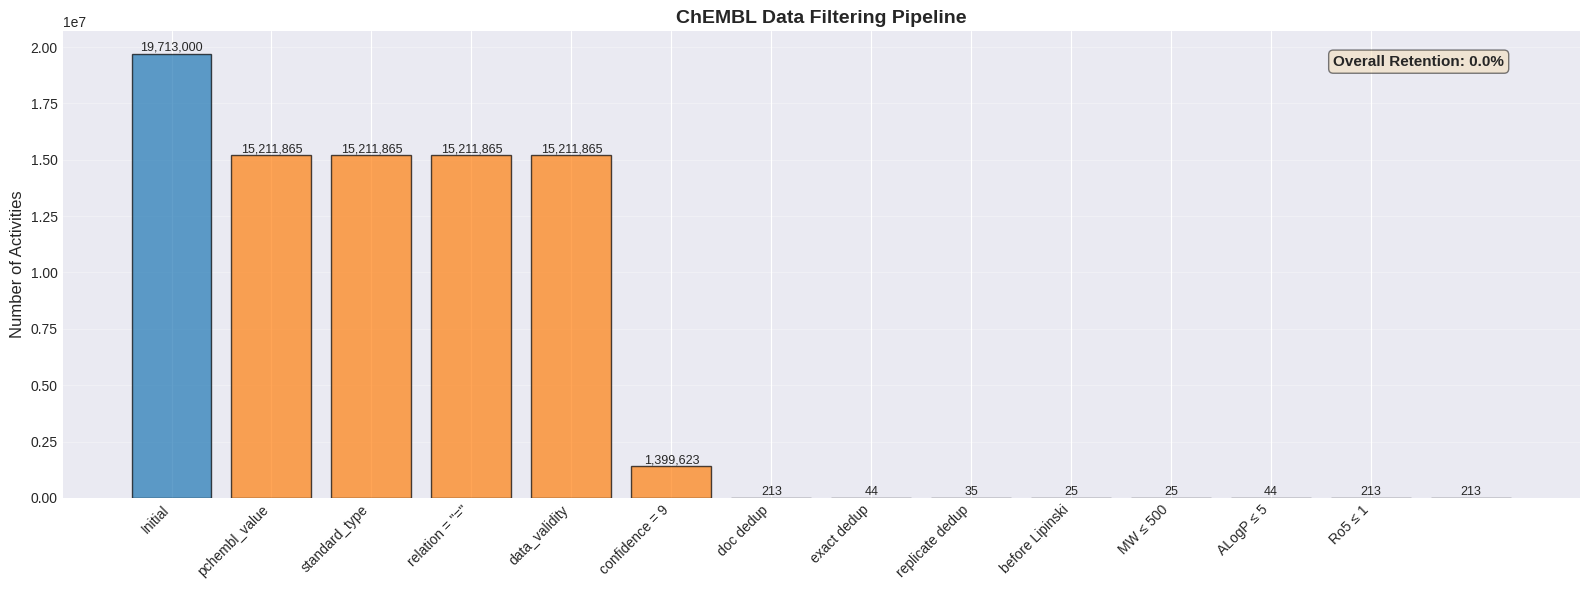

In [ ]:
# Create filtering waterfall chart
fig, ax = plt.subplots(figsize=(16, 6))

stages = list(filter_stats.keys())
values = list(filter_stats.values())
labels = [
    'Initial',
    'pchembl_value',
    'standard_type',
    'relation = "="',
    'data_validity',
    'confidence = 9',
    'doc dedup',
    'exact dedup',
    'replicate dedup',
    'before Lipinski',
    'MW ≤ 500',
    'ALogP ≤ 5',
    'Ro5 ≤ 1'
]

# Bar plot - quality filters (orange), dedup steps (purple), Lipinski (red)
colors = ['#1f77b4'] + ['#ff7f0e']*5 + ['#9467bd']*3 + ['#2ca02c'] + ['#d62728']*3
bars = ax.bar(range(len(values)), values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=9)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of Activities', fontsize=12)
ax.set_title('ChEMBL Data Filtering Pipeline', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add retention percentage annotation
retention = (values[-1] / values[0] * 100)
ax.text(0.95, 0.95, f'Overall Retention: {retention:.1f}%',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

KeyError: 'molecular_weight'

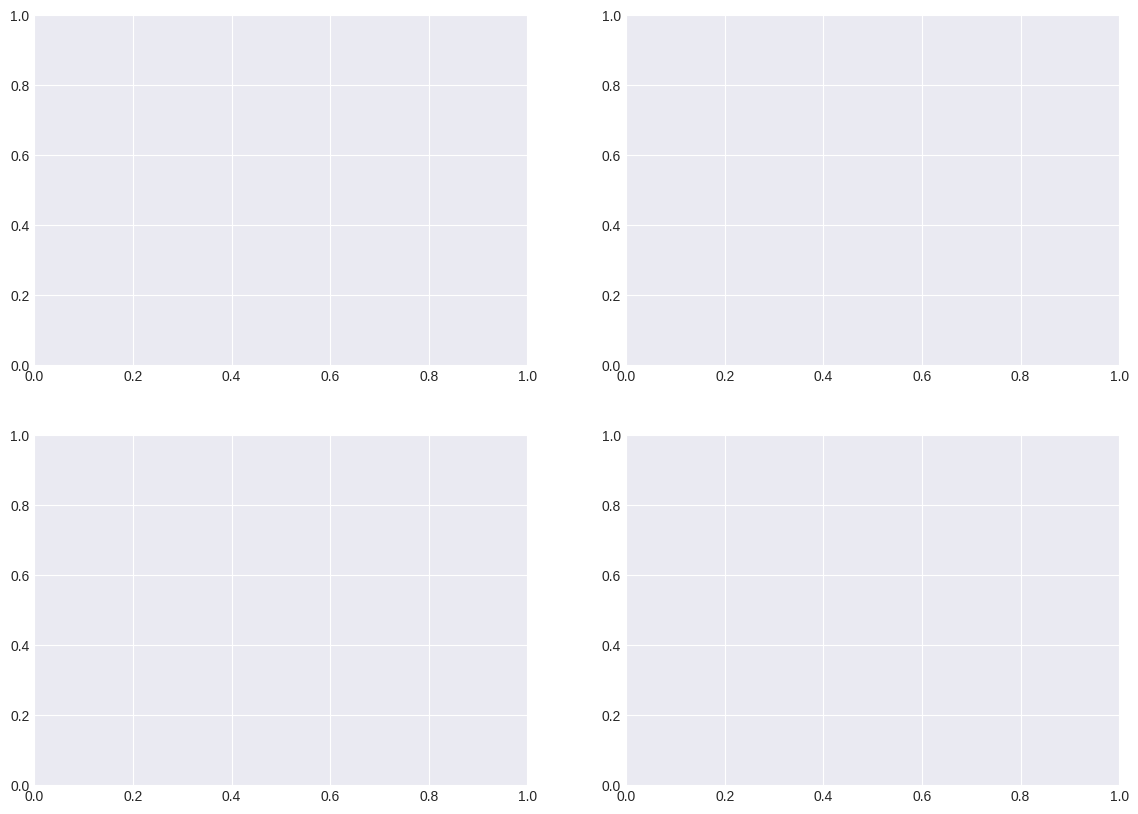

In [ ]:
# Visualize Lipinski properties distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Molecular Weight distribution
ax = axes[0, 0]
ax.hist(df_all['molecular_weight'].dropna(), bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black')
ax.hist(df_lipinski['molecular_weight'].dropna(), bins=50, alpha=0.7, label='After Filtering', color='green', edgecolor='black')
ax.axvline(500, color='red', linestyle='--', linewidth=2, label='Lipinski Cutoff (500 Da)')
ax.set_xlabel('Molecular Weight (Da)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Molecular Weight Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ALogP distribution
ax = axes[0, 1]
ax.hist(df_all['alogp'].dropna(), bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black', range=(-5, 10))
ax.hist(df_lipinski['alogp'].dropna(), bins=50, alpha=0.7, label='After Filtering', color='green', edgecolor='black', range=(-5, 10))
ax.axvline(5, color='red', linestyle='--', linewidth=2, label='Lipinski Cutoff (5)')
ax.set_xlabel('ALogP', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Lipophilicity (ALogP) Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Rule of 5 violations
ax = axes[1, 0]
ro5_initial = df_all['num_ro5_violations'].value_counts().sort_index()
ro5_final = df_lipinski['num_ro5_violations'].value_counts().sort_index()
x = np.arange(len(ro5_initial))
width = 0.35
ax.bar(x - width/2, ro5_initial.values, width, label='Initial', alpha=0.7, color='blue', edgecolor='black')
ax.bar(x + width/2, ro5_final.values, width, label='After Filtering', alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Number of Ro5 Violations', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Rule of 5 Violations', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ro5_initial.index)
ax.legend()
ax.grid(alpha=0.3)

# Standard type distribution
ax = axes[1, 1]
std_type_final = df_lipinski['standard_type'].value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(std_type_final)))
wedges, texts, autotexts = ax.pie(std_type_final.values, labels=std_type_final.index, autopct='%1.1f%%',
                                    colors=colors_pie, startangle=90, textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
ax.set_title('Standard Type Distribution (Final)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Save Filtered Dataset

In [ ]:
# Save filtered dataset to parquet
print("Saving filtered dataset...")
df_lipinski.to_parquet(output_file, index=False)
print(f"✓ Filtered data saved to: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1e6:.1f} MB")
print(f"  Total records: {len(df_lipinski):,}")

# Save summary statistics to JSON
summary_file = output_file.parent / 'filtering_summary.json'
summary_data = {
    'filtering_date': pd.Timestamp.now().isoformat(),
    'input_directory': str(raw_data_dir),
    'output_file': str(output_file),
    'filter_stages': filter_stats,
    'final_statistics': {
        'total_activities': len(df_lipinski),
        'unique_compounds': int(df_lipinski['molecule_chembl_id'].nunique()),
        'unique_uniprot_ids': int(df_lipinski['source_uniprot_id'].nunique()),
        'unique_assays': int(df_lipinski['assay_chembl_id'].nunique()),
        'unique_targets': int(df_lipinski['target_chembl_id'].nunique()),
        'standard_type_distribution': df_lipinski['standard_type'].value_counts().to_dict()
    },
    'quality_filters': {
        'pchembl_value': 'not null',
        'standard_type': ['IC50', 'Ki', 'Kd', 'EC50'],
        'standard_relation': '=',
        'data_validity_comment': 'null',
        'confidence_score': 9,
        'mutants_variants': 'excluded'
    },
    'lipinski_filters': {
        'molecular_weight': '≤ 500 Da',
        'alogp': '≤ 5',
        'num_ro5_violations': '≤ 1'
    },
    'retention_rate': {
        'quality_filtering': f"{len(df_filtered)/len(df_all)*100:.2f}%",
        'lipinski_filtering': f"{len(df_lipinski)/len(df_filtered)*100:.2f}%",
        'overall': f"{len(df_lipinski)/len(df_all)*100:.2f}%"
    }
}

with open(summary_file, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"✓ Summary saved to: {summary_file}")

# Also save as CSV for easy viewing
csv_summary = summary.copy()
csv_file = output_file.parent / 'filtering_statistics.csv'
csv_summary.to_csv(csv_file, index=False)
print(f"✓ Statistics table saved to: {csv_file}")

Saving filtered dataset...
✓ Filtered data saved to: data/chembl_filtered.parquet
  File size: 0.0 MB
  Total records: 0
✓ Summary saved to: data/filtering_summary.json
✓ Statistics table saved to: data/filtering_statistics.csv


## 9. Per-UniProt Summary

Analyze how many compounds and activities remain for each UniProt ID after filtering.

In [ ]:
# Create per-UniProt summary
per_uniprot = df_lipinski.groupby('source_uniprot_id').agg({
    'activity_id': 'count',
    'molecule_chembl_id': 'nunique',
    'assay_chembl_id': 'nunique',
    'target_pref_name': 'first',
    'standard_type': lambda x: x.value_counts().to_dict()
}).rename(columns={
    'activity_id': 'num_activities',
    'molecule_chembl_id': 'num_unique_compounds',
    'assay_chembl_id': 'num_unique_assays',
    'target_pref_name': 'target_name',
    'standard_type': 'standard_type_distribution'
})

per_uniprot = per_uniprot.sort_values('num_activities', ascending=False)

print(f"Per-UniProt Summary (Top 20 by activity count):")
display(per_uniprot.head(20))

# Save per-UniProt summary
per_uniprot_file = output_file.parent / 'per_uniprot_summary.csv'
per_uniprot_simple = per_uniprot.drop('standard_type_distribution', axis=1)
per_uniprot_simple.to_csv(per_uniprot_file)
print(f"\n✓ Per-UniProt summary saved to: {per_uniprot_file}")

Per-UniProt Summary (Top 20 by activity count):


,num_activities,num_unique_compounds,num_unique_assays,target_name,standard_type_distribution
source_uniprot_id,,,,,



✓ Per-UniProt summary saved to: data/per_uniprot_summary.csv


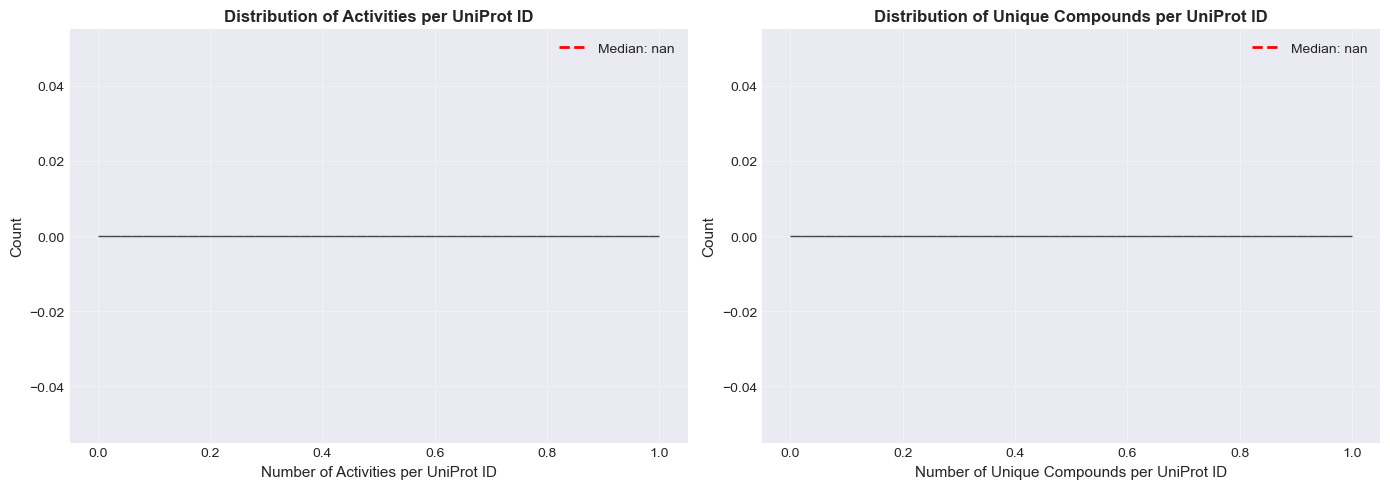


Per-UniProt Statistics:
  Median activities per UniProt: nan
  Mean activities per UniProt: nan
  Median compounds per UniProt: nan
  Mean compounds per UniProt: nan


In [ ]:
# Visualize per-UniProt distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Activities per UniProt
ax = axes[0]
activities_dist = per_uniprot['num_activities'].values
ax.hist(activities_dist, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Number of Activities per UniProt ID', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Activities per UniProt ID', fontsize=12, fontweight='bold')
ax.axvline(np.median(activities_dist), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(activities_dist):.0f}')
ax.legend()
ax.grid(alpha=0.3)

# Compounds per UniProt
ax = axes[1]
compounds_dist = per_uniprot['num_unique_compounds'].values
ax.hist(compounds_dist, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Number of Unique Compounds per UniProt ID', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Unique Compounds per UniProt ID', fontsize=12, fontweight='bold')
ax.axvline(np.median(compounds_dist), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(compounds_dist):.0f}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPer-UniProt Statistics:")
print(f"  Median activities per UniProt: {np.median(activities_dist):.0f}")
print(f"  Mean activities per UniProt: {np.mean(activities_dist):.1f}")
print(f"  Median compounds per UniProt: {np.median(compounds_dist):.0f}")
print(f"  Mean compounds per UniProt: {np.mean(compounds_dist):.1f}")

## 10. Final Summary

All filtering complete! The filtered dataset is ready for downstream analysis.

In [ ]:
print("="*80)
print("FILTERING PIPELINE COMPLETE")
print("="*80)
print(f"\n✓ Input: {len(activity_files)} UniProt activity files from data/raw/")
print(f"✓ Output: {output_file}")
print(f"\n📊 Final Dataset Statistics:")
print(f"  • Total activities: {len(df_lipinski):,}")
print(f"  • Unique compounds: {df_lipinski['molecule_chembl_id'].nunique():,}")
print(f"  • Unique UniProt IDs: {df_lipinski['source_uniprot_id'].nunique():,}")
print(f"  • Unique assays: {df_lipinski['assay_chembl_id'].nunique():,}")
print(f"  • Unique targets: {df_lipinski['target_chembl_id'].nunique():,}")

print(f"\n🎯 Quality Filters Applied:")
print(f"  • pchembl_value: not null")
print(f"  • standard_type: IC50, Ki, Kd, EC50")
print(f"  • standard_relation: = (exact)")
print(f"  • data_validity: valid")
print(f"  • confidence_score: 9 (high confidence)")
print(f"  • mutants/variants: excluded")

print(f"\n💊 Lipinski's Rule of 5 Filters Applied:")
print(f"  • Molecular Weight ≤ 500 Da")
print(f"  • ALogP ≤ 5")
print(f"  • Ro5 violations ≤ 1")

print(f"\n📈 Retention Rates:")
print(f"  • After quality filtering: {len(df_filtered)/len(df_all)*100:.1f}%")
print(f"  • After Lipinski filtering: {len(df_lipinski)/len(df_filtered)*100:.1f}%")
print(f"  • Overall retention: {len(df_lipinski)/len(df_all)*100:.1f}%")

print(f"\n📁 Output Files:")
print(f"  • Filtered data: {output_file}")
print(f"  • Summary JSON: {summary_file}")
print(f"  • Statistics CSV: {csv_file}")
print(f"  • Per-UniProt summary: {per_uniprot_file}")

print(f"\n✅ Pipeline complete! Ready for downstream analysis.")

FILTERING PIPELINE COMPLETE

✓ Input: 361 UniProt activity files from data/raw/
✓ Output: data/chembl_filtered.parquet

📊 Final Dataset Statistics:
  • Total activities: 0
  • Unique compounds: 0
  • Unique UniProt IDs: 0
  • Unique assays: 0
  • Unique targets: 0

🎯 Quality Filters Applied:
  • pchembl_value: not null
  • standard_type: IC50, Ki, Kd, EC50
  • standard_relation: = (exact)
  • data_validity: valid
  • confidence_score: 9 (high confidence)
  • mutants/variants: excluded

💊 Lipinski's Rule of 5 Filters Applied:
  • Molecular Weight ≤ 500 Da
  • ALogP ≤ 5
  • Ro5 violations ≤ 1

📈 Retention Rates:
  • After quality filtering: 77.2%
  • After Lipinski filtering: 0.0%
  • Overall retention: 0.0%

📁 Output Files:
  • Filtered data: data/chembl_filtered.parquet
  • Summary JSON: data/filtering_summary.json
  • Statistics CSV: data/filtering_statistics.csv
  • Per-UniProt summary: data/per_uniprot_summary.csv

✅ Pipeline complete! Ready for downstream analysis.


In [7]:
import pandas as pd
import glob
import os
import numpy as np
import hashlib

# Define input file pattern
input_pattern = "data/chembl_parallel_enriched_part1/uniprot_*/*_chembl_activities.parquet"

# Find all parquet files
files = glob.glob(input_pattern)
print(f"Found {len(files)} files.")

# Load and concatenate
dfs = []
for f in files:
    try:
        df = pd.read_parquet(f)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    print(f"Total records loaded: {len(full_df)}")
else:
    print("No data loaded.")
    full_df = pd.DataFrame()

full_df.head()

Found 1026 files.
Total records loaded: 1040579


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_tissue_chembl_id,assay_target_chembl_id,assay_document_chembl_id,assay_src_id,assay_src_assay_id,assay_category,assay_parameters,assay_classifications,assay_variant_sequence,source_uniprot_id
0,None,None,3520859,[],CHEMBL1273313,Binding affinity to RAP1A in human RBC membran...,B,None,None,BAO_0000034,...,None,CHEMBL1255139,CHEMBL1268998,1,None,None,None,None,None,P62834
1,None,None,3520860,[],CHEMBL1273311,Binding affinity to RAP1A in human RBC membran...,B,None,None,BAO_0000034,...,None,CHEMBL1255139,CHEMBL1268998,1,None,None,None,None,None,P62834
2,None,None,3520861,[],CHEMBL1273312,Binding affinity to RAP1A in human RBC membran...,B,None,None,BAO_0000034,...,None,CHEMBL1255139,CHEMBL1268998,1,None,None,None,None,None,P62834
3,None,None,12187738,[],CHEMBL2208523,Inhibition of Rap1a,B,None,None,BAO_0000188,...,None,CHEMBL1255139,CHEMBL2203227,1,494264,None,None,None,None,P62834
4,None,None,12187739,[],CHEMBL2208523,Inhibition of Rap1a,B,None,None,BAO_0000188,...,None,CHEMBL1255139,CHEMBL2203227,1,494264,None,None,None,None,P62834


## 2. Base Filtering

Filter based on:
*   `standard_type`: 'Ki' or 'IC50'
*   `standard_units`: 'nM'
*   `standard_relation`: '='
*   `data_validity_comment`: null (valid)
*   `assay_confidence_score`: 9 (High Confidence)
*   `document_year`: Not null (onlyDocs)
*   Mutant filtering: Remove assays with "mutant", "mutation", "variant" in description.

In [8]:
def apply_base_filters(df):
    print(f"Initial count: {len(df)}")
    
    # 1. Standard Type
    df = df[df['standard_type'].isin(['Ki', 'IC50'])]
    print(f"After Type filter: {len(df)}")
    
    # 2. Standard Units
    df = df[df['standard_units'] == 'nM']
    print(f"After Units filter: {len(df)}")
    
    # 3. Standard Relation
    df = df[df['standard_relation'] == '=']
    print(f"After Relation filter: {len(df)}")
    
    # 4. Data Validity
    df = df[df['data_validity_comment'].isnull()]
    print(f"After Validity filter: {len(df)}")
    
    # 5. Confidence Score
    # Note: assay_confidence_score might be numeric or string, checking both just in case or converting
    df['assay_confidence_score'] = pd.to_numeric(df['assay_confidence_score'], errors='coerce')
    df = df[df['assay_confidence_score'] == 9]
    print(f"After Confidence filter: {len(df)}")
    
    # 6. Only Docs (Document Year not null)
    df = df[df['document_year'].notnull()]
    print(f"After Docs filter: {len(df)}")
    
    # 7. Mutant Filtering
    # Check assay_description for keywords
    mutant_keywords = ['mutant', 'mutation', 'variant']
    # Ensure assay_description is string and handle NaNs
    mask = df['assay_description'].astype(str).str.lower().apply(lambda x: any(k in x for k in mutant_keywords))
    df = df[~mask]
    print(f"After Mutant filter: {len(df)}")
    
    return df

filtered_df = apply_base_filters(full_df)

Initial count: 1040579
After Type filter: 887080
After Units filter: 834307
After Relation filter: 642515
After Validity filter: 628957
After Confidence filter: 360191
After Docs filter: 356010
After Mutant filter: 347026


## 3. Assay Size Filtering

Keep assays with compound count between `minAssaySize` (20) and `maxAssaySize` (100).
Note: We group by `assay_chembl_id` to count compounds.

In [9]:
minAssaySize = 10 # Adjusted for small test dataset
maxAssaySize = 3000

# Count compounds per assay
assay_counts = filtered_df.groupby('assay_chembl_id').size()
print("Assay counts distribution:")
print(assay_counts.describe())
print("\nTop 5 assays by size:")
print(assay_counts.sort_values(ascending=False).head())

# Filter assays
valid_assays = assay_counts[(assay_counts >= minAssaySize) & (assay_counts <= maxAssaySize)].index
filtered_df = filtered_df[filtered_df['assay_chembl_id'].isin(valid_assays)]

print(f"After Assay Size filter: {len(filtered_df)} records from {len(valid_assays)} assays.")

Assay counts distribution:
count    34132.000000
mean        10.167174
std         27.888839
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max       1097.000000
dtype: float64

Top 5 assays by size:
assay_chembl_id
CHEMBL5738760    1097
CHEMBL5731107     978
CHEMBL3706373     745
CHEMBL3705362     729
CHEMBL3705476     664
dtype: int64
After Assay Size filter: 285968 records from 9297 assays.


## 4. Overlap Detection & Unit Error Correction

Identify pairs of assays that test the same compounds (using `canonical_smiles`) against the same target.
We will perform a self-join on the dataframe to find these pairs.

*   `noDuplicateDocs`: Ensure assays are from different documents.
*   `includeActivityCuration`: Remove pairs with pChEMBL difference of exactly 3.0.
*   `maxMatch`: Enforce metadata matching.

In [11]:
def find_overlaps(group, max_match=True):
    # group is a dataframe for a specific target
    
    # Self merge on canonical_smiles
    # We only want pairs where assay_chembl_id_1 < assay_chembl_id_2 to avoid duplicates and self-matches
    merged = pd.merge(group, group, on='canonical_smiles', suffixes=('_1', '_2'))
    
    # Filter for different assays
    merged = merged[merged['assay_chembl_id_1'] < merged['assay_chembl_id_2']]
    
    if merged.empty:
        return pd.DataFrame()

    # 1. No Duplicate Docs (Different Documents)
    merged = merged[merged['document_chembl_id_1'] != merged['document_chembl_id_2']]
    
    # 2. Unit Error Correction (pChEMBL diff != 3.0)
    # Ensure pchembl_value is numeric
    merged['pchembl_value_1'] = pd.to_numeric(merged['pchembl_value_1'], errors='coerce')
    merged['pchembl_value_2'] = pd.to_numeric(merged['pchembl_value_2'], errors='coerce')
    
    merged = merged[abs(merged['pchembl_value_1'] - merged['pchembl_value_2']) != 3.0]
    
    # 3. Matching Assay Metadata (Max Curation)
    if max_match:
        metadata_cols = [
            'assay_organism_enriched', 
            'assay_tissue_enriched', 
            'assay_cell_type_enriched', 
            'assay_subcellular_fraction_enriched', 
            'assay_bao_format_enriched',
            # 'assay_variant_accession', 
            # 'assay_variant_mutation'
        ]
        
        # Check which columns actually exist in the dataframe
        existing_metadata_cols = [c for c in metadata_cols if c in group.columns]
        
        for col in existing_metadata_cols:
            # Handle NaNs: if both are NaN, they match. If one is NaN, they don't.
            merged = merged[merged[f'{col}_1'].fillna('MISSING') == merged[f'{col}_2'].fillna('MISSING')]
        
    return merged

# --- 1. Minimal Curation (Only Activity) ---
print("Running Minimal Curation (max_match=False)...")
overlap_results_min = []
for target, group in filtered_df.groupby('target_chembl_id'):
    overlaps = find_overlaps(group, max_match=False)
    if not overlaps.empty:
        overlap_results_min.append(overlaps)

if overlap_results_min:
    all_overlaps_min = pd.concat(overlap_results_min, ignore_index=True)
    print(f"Minimal Curation: Found {len(all_overlaps_min)} overlapping pairs.")
else:
    print("Minimal Curation: No overlaps found.")
    all_overlaps_min = pd.DataFrame()


# --- 2. Maximal Curation (With Metadata Matching) ---
print("\nRunning Maximal Curation (max_match=True)...")
overlap_results_max = []
for target, group in filtered_df.groupby('target_chembl_id'):
    overlaps = find_overlaps(group, max_match=True)
    if not overlaps.empty:
        overlap_results_max.append(overlaps)

if overlap_results_max:
    all_overlaps_max = pd.concat(overlap_results_max, ignore_index=True)
    print(f"Maximal Curation: Found {len(all_overlaps_max)} overlapping pairs.")
else:
    print("Maximal Curation: No overlaps found.")
    all_overlaps_max = pd.DataFrame()

Running Minimal Curation (max_match=False)...
Minimal Curation: Found 61320 overlapping pairs.

Running Maximal Curation (max_match=True)...
Maximal Curation: Found 44556 overlapping pairs.


# Plotting Overlap Results

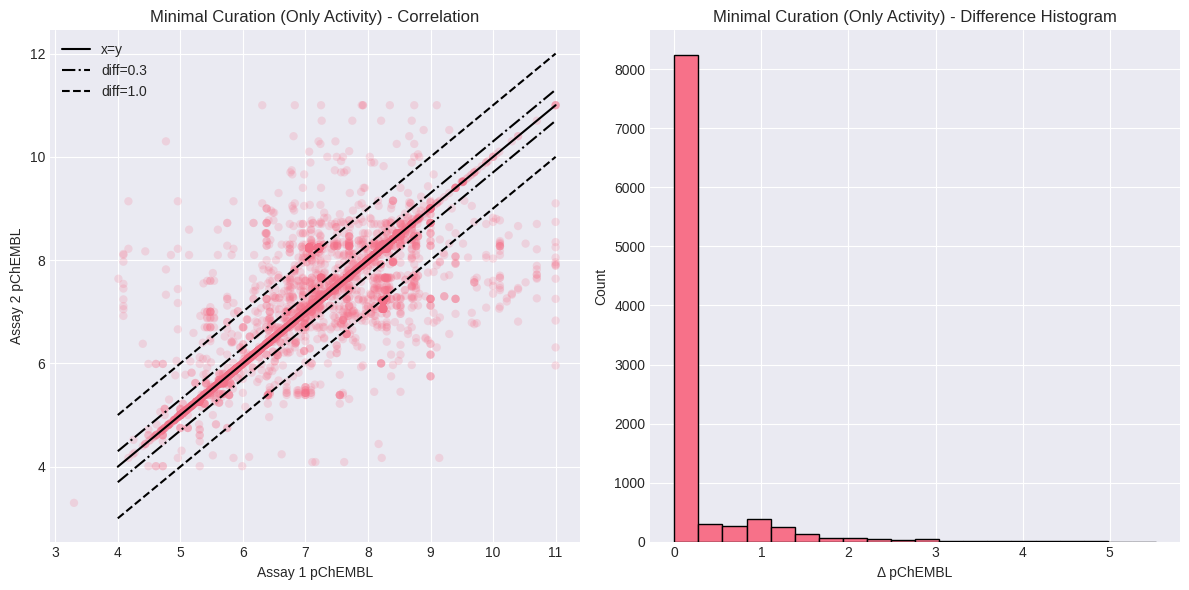

Statistics for Minimal Curation (Only Activity):
  Number of points: 9832
  R2: 0.67
  Spearman R: 0.72
  MAE: 0.00
  Points > 0.3: 1545 (15.71%)
  Points > 1.0: 911 (9.27%)


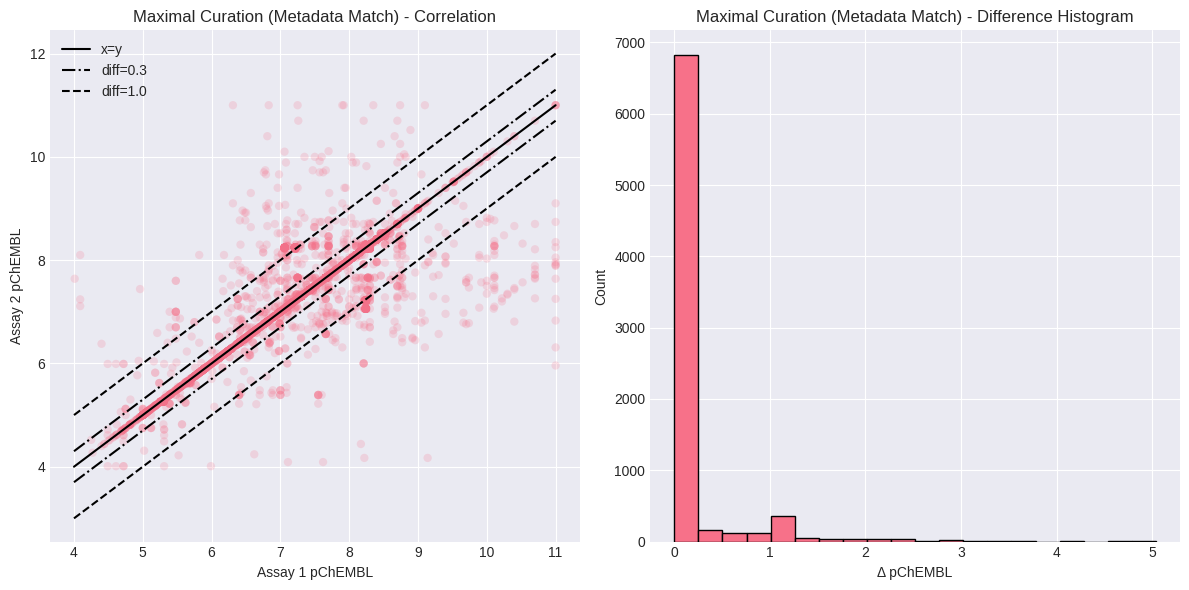

Statistics for Maximal Curation (Metadata Match):
  Number of points: 7849
  R2: 0.73
  Spearman R: 0.75
  MAE: 0.00
  Points > 0.3: 987 (12.57%)
  Points > 1.0: 630 (8.03%)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, median_absolute_error

def plot_agreement(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    plt.figure(figsize=(12, 6))
    
    # Extract pChEMBL values
    xp = df['pchembl_value_1'].values
    yp = df['pchembl_value_2'].values
    
    # Left Plot: Correlation
    plt.subplot(1, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    
    # Add reference lines
    line_min, line_max = 4, 11
    plt.plot((line_min, line_max), (line_min, line_max), 'k-', label='x=y') 
    plt.plot((line_min, line_max), (line_min - 0.3, line_max - 0.3), 'k-.', label='diff=0.3')
    plt.plot((line_min, line_max), (line_min + 0.3, line_max + 0.3), 'k-.')
    plt.plot((line_min, line_max), (line_min - 1.0, line_max - 1.0), 'k--', label='diff=1.0')
    plt.plot((line_min, line_max), (line_min + 1.0, line_max + 1.0), 'k--')
    
    plt.xlabel('Assay 1 pChEMBL')
    plt.ylabel('Assay 2 pChEMBL')
    plt.title(f'{title} - Correlation')
    plt.legend()
    
    # Right Plot: Histogram of differences
    plt.subplot(1, 2, 2)
    delts = np.abs(xp - yp)
    
    # Plot histogram
    n, bins, patches = plt.hist(delts, bins=20, edgecolor='black')
    plt.xlabel('Δ pChEMBL')
    plt.ylabel('Count')
    plt.title(f'{title} - Difference Histogram')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Statistics
    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    mae = median_absolute_error(xp, yp)
    npts = len(delts)
    
    # Count points > 0.3 and > 1.0
    count_03 = np.sum(delts > 0.3)
    frac_03 = count_03 / npts
    
    count_10 = np.sum(delts > 1.0)
    frac_10 = count_10 / npts
    
    print(f"Statistics for {title}:")
    print(f"  Number of points: {npts}")
    print(f"  R2: {r2:.2f}")
    print(f"  Spearman R: {r:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  Points > 0.3: {count_03} ({frac_03:.2%})")
    print(f"  Points > 1.0: {count_10} ({frac_10:.2%})")

# Plot Minimal Curation
if 'all_overlaps_min' in locals():
    plot_agreement(all_overlaps_min, "Minimal Curation (Only Activity)")

# Plot Maximal Curation
if 'all_overlaps_max' in locals():
    plot_agreement(all_overlaps_max, "Maximal Curation (Metadata Match)")

## 5. Save Results

Save the overlapping data pairs.

In [ ]:
if 'all_overlaps_max' in locals() and not all_overlaps_max.empty:
    output_file = "data/output/chembl_filtered_overlaps.parquet"
    all_overlaps_max.to_parquet(output_file)
    print(f"Saved maximal curation overlaps to {output_file}")
else:
    print("Nothing to save.")

Saved maximal curation overlaps to data/output/chembl_filtered_overlaps.parquet
